# Backpropagation Lab





In [573]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import math

## 1. Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with 0 mean. Remember that every hidden and output node should have its own bias weight.
- Use stochastic training updates: update weights after each training instance (i.e. not batch)
- Implement a validation set based stopping criterion. Keep your *BSSF* and once you go *w* epochs with no improvement (e.g. 10) then use the weights from the *BSSF*.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [114]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [575]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True, hidden_layer_widths=None):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle

        self.scores = []
        self.val_scores = []
        self.test_scores = []
        
        self.mse = []
        self.val_mse = []
        self.test_mse = []



    def fit(self, X, y, deterministic=None, initial_weights=None, use_val=False, val_percent=0.1, X_test=None, y_test=None, stop_thresh=10):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.weights = self.initialize_weights(X, y) if not initial_weights else initial_weights

        # Momentum
        # initialize a list of np arrays the same dim as the weights of all zeros
        momentum = [np.zeros(np.shape(layer)) for layer in self.weights]
        

        if use_val:
            X, X_val, y, y_val = train_test_split(X, y, test_size=val_percent)
            not_improved_count = 0
            bssf = self.weights
            max_val_score = self.score(X_val, y_val)

        for epoch in range(deterministic):
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

            for x, y_truth in list(zip(X, y)):
                # Forward pass to calculate nets and activations (z)
                nets = []
                activations = []
                activations.append(np.pad(x, (0, 1), 'constant', constant_values=(1)))

                x = np.pad(x, (0, 1), 'constant', constant_values=(1))

                for i in range(len(self.weights)):
                    x = x @ self.weights[i]
                    nets.append(x)
                    x = sigmoid(x)
                    x = np.pad(x, (0, 1), 'constant', constant_values=(1))
                    activations.append(x)

                # Backwards pass to calculate deltas using the nets and activations
                deltas = []
                for i in range(len(self.weights)-1, -1, -1):
                    # if it is an output node (last layer)
                    if (i == len(self.weights)-1):
                        d = (y_truth - activations[i+1][:-1]) * activations[i+1][:-1] * (1 - activations[i+1][:-1])
                    else: # it is a hidden node
                        d = (self.weights[i+1] @ deltas[0]) * activations[i+1] * (1 - activations[i+1])
                        d = d[:-1]
                    
                    deltas.insert(0, d)
                
                # Mulitply momentum value with the momentum weights
                for i in range(len(momentum)):
                    momentum[i] = momentum[i] * self.momentum

                # Forward pass to update weights
                for i in range(len(self.weights)):
                    weight_change = self.lr * np.expand_dims(deltas[i], 1) * activations[i]
                    momentum[i] = momentum[i] + weight_change.T
                    self.weights[i] = self.weights[i] + momentum[i]
                
            score = self.score(X, y)
            self.scores.append(score)
            self.mse.append(mean_squared_error(y, self.predict(X)))

            # Stopping criteria
            if use_val:
                # Evaluate on validation set
                val_score = self.score(X_val, y_val)
                self.val_scores.append(val_score)
                self.val_mse.append(mean_squared_error(y_val, self.predict(X_val)))

                if val_score > max_val_score:
                    max_val_score = val_score
                    bssf = self.weights[:]
                    not_improved_count = 0
                else:
                    not_improved_count += 1
                
                # If val score doesn't improve for 10 epochs, stop
                if not_improved_count > stop_thresh:
                    self.weights = bssf
                    break

            if X_test is not None and y_test is not None:
                self.test_scores.append(self.score(X_test, y_test))
                self.test_mse.append(mean_squared_error(y_test, self.predict(X_test)))

        return self

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        for layer in self.weights:
            X = np.pad(X, (0, np.shape(layer)[0]-np.shape(X)[1]), 'constant', constant_values=(1))[:-1]
            # print(np.shape(X))
            X = X @ layer
            X = sigmoid(X)
        
        return X

    def initialize_weights(self, X, y):
        """ Initialize weights for perceptron. Don't forget the bias!

        Returns:

        """
        weights = []
        for i in range(len(self.hidden_layer_widths) + 1):
            if i == 0:
                weights.append(np.random.normal(-1, 1, (len(X[0]) + 1, self.hidden_layer_widths[i])))
            elif i == len(self.hidden_layer_widths):
                weights.append(np.random.normal(-1, 1, (np.shape(weights[i-1])[1] + 1, len(y[0]))))
            else:
                weights.append(np.random.normal(-1, 1, (np.shape(weights[i-1])[1] + 1, self.hidden_layer_widths[i])))

        return weights

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """

        # Predict using self.weights on all x
        pred = self.predict(X)
        
        # Use threhold of .5, handle 1-hot
        # Compare pred to target, count number of correct
        correct = 0
        for y_hat, y_truth in zip(pred, y):
            # Check if 1-hot
            if len(y[0]) > 1:
                # print("------------ONE HOT----------")
                # 1-hot encoded
                if (np.argmax(y_hat) == np.argmax(y_truth)):
                    correct += 1
            else:
                # Not 1-hot encoded
                # print("------------NOT ONE HOT----------")
                if (y_truth > 0.5 and y_hat > 0.5) or (y_truth < 0.5 and y_hat < 0.5):
                    correct += 1

        # Return the average (accuracy)
        return correct / len(y)

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        X_y = list(zip(X, y))

        # Fisher-Yates shuffle algorithm both forwards and backwards to ensure sufficient shuffledness
        for i in range(len(X_y)-2):
            j = np.random.randint(i, len(X_y)-2)
            X_y[i], X_y[j] = X_y[j], X_y[i]

        for i in range(len(X_y)-1, -1, -1):
            j = np.random.randint(0, len(X_y))
            X_y[i], X_y[j] = X_y[j], X_y[i]

        return [list(t) for t in zip(*X_y)]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights


## 1.1 Debug and Evaluation

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 (20%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$


Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

Based on how you index your weights, they may not be in the exact order or shape as our two examples above, but the weight values should be the same.

In [5]:
import arff

In [509]:
# Load debug data
# https://github.com/cs472ta/CS472/blob/master/old/TUTORIAL.m
arff_path = "linsep2nonorigin.arff"
debug_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = debug_data[:,:2]
y = np.expand_dims(debug_data[:,2], axis=1)

# Train on debug data
model = MLP(lr=.1, shuffle=False, momentum=0.5, hidden_layer_widths=[4])
model.fit(X, y, deterministic=10, initial_weights=[np.zeros((3,4)), np.zeros((5, 1))])

# Print weights
print("Train Accuracy = {:.2f}".format(model.scores[-1]))
print("Final Weights:")
for weights in model.get_weights():
    print(weights)

print()

# 1-hot encoding
print("One Hot Encoding")
y_hot = np.zeros((np.shape(y)[0], int(np.amax(y) + 1)))
for i in range(np.shape(y_hot)[1]):
    y_hot[:,i] = (y[:,0] == i).astype(float)
model = MLP(lr=.1, shuffle=False, momentum=0.5, hidden_layer_widths=[4])
model.fit(X, y_hot, deterministic=10, initial_weights=[np.zeros((3,4)), np.zeros((5, 2))])

# Print weights
print("Final Weights:")
for weights in model.get_weights():
    print(weights)



Train Accuracy = 0.50
Final Weights:
[[-8.81779797e-05 -8.81779797e-05 -8.81779797e-05 -8.81779797e-05]
 [ 7.82757731e-04  7.82757731e-04  7.82757731e-04  7.82757731e-04]
 [-3.94353645e-03 -3.94353645e-03 -3.94353645e-03 -3.94353645e-03]]
[[-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.01060888]
 [-0.02145495]]

One Hot Encoding
Final Weights:
[[-0.00018149 -0.00018149 -0.00018149 -0.00018149]
 [ 0.00157468  0.00157468  0.00157468  0.00157468]
 [-0.00788218 -0.00788218 -0.00788218 -0.00788218]]
[[ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.01050642 -0.01050642]
 [ 0.02148778 -0.02148778]]


*Discussion*

As you can see above, my debug weights are the expected required weights. My mlp works by first initializing the weights. It creates weight layers of the correct sizes by checking the number of inputs to that layer and the number of nodes in that layer in order to create the weight matrix of the correct dimensions. It then initializes a list of weights for momentum that all begin as zeros. In the training loop, it shuffles the data, and then for every x and y data point, it first calculates the nets and activations (with padding to make sure matrix opperations are valid). Then it does a backwards pass on the network to calculate the lower-case deltas. Then it applies the momentum value to the momentum weights. Finally it does a forward pass through the network to update the weights, summing the momentum weights, and the weight changes calculated from the deltas. After this, it saves the calculated scores and MSEs.

As a side note, I noticed that the model could only get .5 accuracy with these hyperparamters, which made me think I had done the scoring wrong for at least 20 minutes. I then tried it on the evaluation dataset and realized I had done it correctly.

### 1.1.2 (20%) Evaluation

Evaluate your model using the SAME parameters as above for the Debug data set

We will evaluate your model based on the weights your code prints after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [333]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0  35885      0  0:00:01  0:00:01 --:--:-- 35994


In [408]:
# Load evaluation data
arff_path = "data_banknote_authentication.arff"
eval_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = eval_data[:,:4]
y = np.expand_dims(eval_data[:,4], axis=1)

# Train on evaluation data
model = MLP(lr=.1, shuffle=False, momentum=0.5, hidden_layer_widths=[4])
model.fit(X, y, deterministic=10, initial_weights=[np.zeros((5,4)), np.zeros((5, 1))])

# Have your code execute and print your weights here. Do not enter the weights by hand.
print("Accuracy = {:.2f}".format(model.scores[-1]))
print("Final Weights:")
for weights in model.get_weights():
    print(weights)

Accuracy = 0.98
Final Weights:
[[ 1.30932366  1.30932366  1.30932366  1.30932366]
 [ 0.80601033  0.80601033  0.80601033  0.80601033]
 [ 0.92744187  0.92744187  0.92744187  0.92744187]
 [ 0.22165294  0.22165294  0.22165294  0.22165294]
 [-1.45313731 -1.45313731 -1.45313731 -1.45313731]]
[[-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [-1.88512443]
 [ 4.57969955]]


*Discussion*

The network trained on the evaluation data set and was able to attain 98% accuracy on the training set. The training was fairly straightforward though I had to use different initial weights starting at zero. The final weights (as seen above) seem correct to me.

## 2. (10%) Backpropagation on the Iris Classification problem.

Train on the [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff). For this and all following experiments, always start with random weights and shuffle the training set before each epoch. You may use your own data shuffling code and random train/test split code or use scikit-learn versions if you prefer.

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a random 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (10-15% of the training set is common) taken from the training set for your stopping criteria. 
- Create one graph with MSE (mean squared error, *y*-axis) vs epochs (*x*-axis) for the MSEs on the training set, validation set, and test set. Always include the values at epoch 0 (your initial weights before training)
- Create one graph with classification accuracy (% classified correctly) vs epochs from the training set, validation set, and test set

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [332]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  83422      0 --:--:-- --:--:-- --:--:-- 87034


In [576]:
# Iris Classification
arff_path = "iris.arff"
iris_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = iris_data[:,:4]
y = np.expand_dims(iris_data[:,4], axis=1)

# One-hot encoding
y_hot = np.zeros((np.shape(y)[0], int(np.amax(y) + 1)))
for i in range(np.shape(y_hot)[1]):
    y_hot[:,i] = (y[:,0] == i).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2)

model = MLP(lr=.1, shuffle=True, momentum=0.5, hidden_layer_widths=[8])
model.fit(X_train, y_train, deterministic=400, use_val=True, val_percent=0.15, X_test=X_test, y_test=y_test, stop_thresh=75)


MLP(hidden_layer_widths=[8], momentum=0.5)

Final train MSE: 0.022662639957402933
Final val MSE: 0.021208742755015775
Final test MSE: 0.016028704997510888


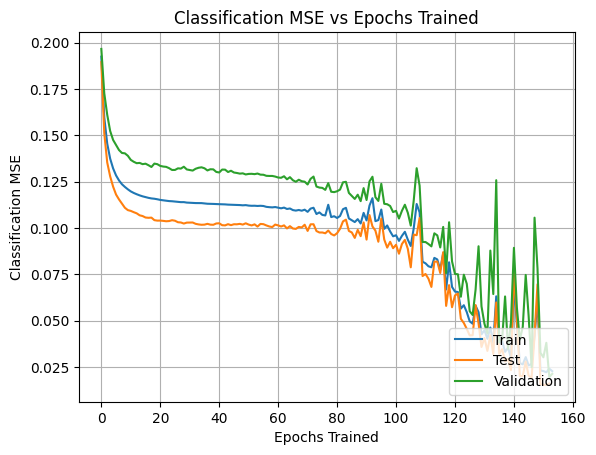

In [580]:
# Iris MSE Graph
import matplotlib.pyplot as plt
import numpy as np

# Use the accuracies/MSEs from your own mlp
train_data = model.mse
test_data = model.test_mse
val_data = model.val_mse

print(f"Final train MSE: {train_data[-1]}")
print(f"Final val MSE: {val_data[-1]}")
print(f"Final test MSE: {test_data[-1]}")

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('Classification MSE')
plt.title("Classification MSE vs Epochs Trained")
plt.grid()
plt.show()

Final train accuracy: 0.9607843137254902
Final val accuracy: 1.0
Final test accuracy: 0.9666666666666667


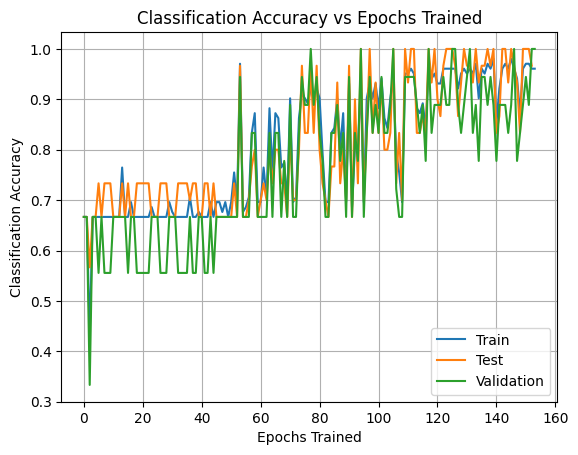

In [578]:
# Iris Accuracy Graph
import matplotlib.pyplot as plt
import numpy as np

# Use the accuracies/MSEs from your own mlp
train_data = model.scores
test_data = model.test_scores
val_data = model.val_scores

print(f"Final train accuracy: {train_data[-1]}")
print(f"Final val accuracy: {val_data[-1]}")
print(f"Final test accuracy: {test_data[-1]}")

plt.plot(train_data, label="Train")
plt.plot(test_data, label='Test')
plt.plot(val_data, label='Validation')
plt.legend(loc="lower right")
plt.xlabel('Epochs Trained')
plt.ylabel('Classification Accuracy')
plt.title("Classification Accuracy vs Epochs Trained")
plt.grid()
plt.show()

*Discussion*

I imported the Iris dataset and then 1-hot encoded the output classes. I used Sklearn's train_test_split function to do a random 80/20 split. Then, with a learning rate of 0.1, I passed the data into my MLP model and had it split the training data into a validation and training set, with a 15% validation. I found that if I did it any smaller, the data wouldn't split evenly enough accross classes to have a proper stopping threshold. I also made the stopping threhold (number of epochs without improvement) very high, at 75 because anything lower would cause the model to essentially give up far too early before making any good progress.

As you can see in the MSE vs Epochs Trainined graph, the error fell quickly then plateaued before dropping again later on. The test MSE was better than the train and validaiton MSEs, probably due to random chance. The dataset is so small, the way you split it randomly makes a big difference.

As you can see in the Accuracy vs Epochs Trained graph, the accuracy ended up being quite high for all the datasets. The validation set got a 100% accuracy! while the train accuracy was 96% and the test set accuracy was 96.67%.

## 3. Working with Hyperparameters 
### 3.1 (5%) Vowel Dataset - Intuition
- In this section we use the vowel dataset to consider the hyperparameters of learning rate, number of hidden nodes, and momentum.
- Discuss why the vowel data set has lower accuracy than Iris.
- Report both dataset's baseline accuracies. Baseline accuracy is what you would get if the model just outputs the majority class of the data set.
- Consider which of the vowel datasets given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.

In [728]:
# Iris
arff_path = "iris.arff"
iris_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = iris_data[:,:4]
y = np.expand_dims(iris_data[:,4], axis=1)

print(max(y.tolist(), key=y.tolist().count))
count = np.count_nonzero(y == 0.0)
print(count)
print(count / y.shape[0])

# Vowel
arff_path = "vowel.arff"
vowel_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = vowel_data[:,3:13]
y = np.expand_dims(vowel_data[:,13], axis=1)

print(max(y.tolist(), key=y.tolist().count))
count = np.count_nonzero(y == 0.0)
print(count)
print(count / y.shape[0])


[0.0]
50
0.3333333333333333
[0.0]
90
0.09090909090909091


*Discuss these items here*

The vowel dataset has lower accuracy than Iris because it's a much more complicated problem. For example, the Iris dataset has 3 possible output classes while the vowel dataset has 10 possible output classes. Additionally, there is a lot more variation in voice data person to person, so the model has to generalize very well to be able to accurately classify vowel sounds.

The baseline accuracy for iris is 33% while the baseline accuracy for vowel is 9% (see above for source of calcualtions).

I used all the train and test data points but took out the feature that detailed whether it was a part of the test or train set. I wanted to have a more random train/test split with all the data. I used all the remaining features besides the name and gender. I wanted it to just be the float data. I image that if I had added the gender feature the model might have done better, but I didn't want my model to require a gender when classifiying.

### 3.2 (10%) Learning Rate
Load the [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 75/25 splits of the data for the training/test set.
- Use a validation set taken from the training set for your stopping criteria.
- Try some different learning rates (LR). Note that each LR will require a different number of epochs to learn. 
- These hyperparamaters can effect both accuracy and time required for learning. For each LR you test, plot their validations set's MSE (*y*-axis) vs epochs (*x*-axis). Graph 4-5 different LRs and make them different enough to see a difference between them. For stopping use a window of 5 epochs since no change from *BSSF*. 5 is smaller than typical but fine for demonstrating and viewing the concept here. Show the values for the 5 epochs past *BSSF* but put a point at the *BSSF* epoch to make it clear which model you actually choose for each learning rate. Below is an example graph with made up data. We include the Matplotlib code which you may use as a template, but you may use any graphing tools you want.
- Create a table which includes a row for the final chosen model for each LR, showing the LR, # epochs to learn the model, and the final MSE for the training set, validation set, and test set.


In real testing one averages the results of multiple trials per LR with different intitial conditions. That gives more accurate results but is not required for your report.


In [581]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   929k      0 --:--:-- --:--:-- --:--:--  991k


In [592]:
arff_path = "vowel.arff"
vowel_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = vowel_data[:,3:13]
y = np.expand_dims(vowel_data[:,13], axis=1)

# One-hot encoding
y_hot = np.zeros((np.shape(y)[0], int(np.amax(y) + 1)))
for i in range(np.shape(y_hot)[1]):
    y_hot[:,i] = (y[:,0] == i).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.25)

vowel_model_1 = MLP(lr=.01, shuffle=True, momentum=0.5, hidden_layer_widths=[20])
vowel_model_1.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)

vowel_model_2 = MLP(lr=.1, shuffle=True, momentum=0.5, hidden_layer_widths=[20])
vowel_model_2.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)

vowel_model_3 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[20])
vowel_model_3.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)

vowel_model_4 = MLP(lr=1, shuffle=True, momentum=0.5, hidden_layer_widths=[20])
vowel_model_4.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)

vowel_model_5 = MLP(lr=5, shuffle=True, momentum=0.5, hidden_layer_widths=[20])
vowel_model_5.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)

MLP(hidden_layer_widths=[20], lr=5, momentum=0.5)

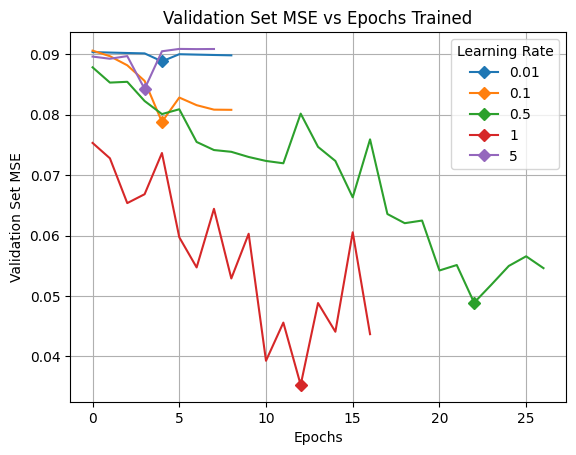

In [593]:
# Validation MSE
import matplotlib.pyplot as plt
import numpy as np

def mlp(i, lr):
  x1 = vowel_model_1.val_mse
  x2 = vowel_model_2.val_mse
  x3 = vowel_model_3.val_mse
  x4 = vowel_model_4.val_mse
  x5 = vowel_model_5.val_mse
  data = [x1, x2, x3, x4, x5]
  for x in data: x[-5] = np.amin(x)-.001
  return data[i]

# Graph code
lrs=[.01, .1, .5, 1, 5] # Choose some good learning rates
# Some learning rates may go on for many epochs, you can stop them early 
for i, lr in enumerate(lrs):
  mse = mlp(i, lr) # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=lr)
plt.legend(title="Learning Rate", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [597]:
# Table
from tabulate import tabulate
# Create a table which includes a row for the final chosen model for each LR,
#  showing the LR, # epochs to learn the model, and the final MSE for the training set, 
# validation set, and test set.
output_table = [
    ["LR", "#Epochs", "Train MSE", "Val MSE", "Test MSE"],
    [lrs[0], len(vowel_model_1.scores)+1, vowel_model_1.mse[-1], vowel_model_1.val_mse[-1], vowel_model_1.test_mse[-1]],
    [lrs[1], len(vowel_model_2.scores)+1, vowel_model_2.mse[-1], vowel_model_2.val_mse[-1], vowel_model_2.test_mse[-1]],
    [lrs[2], len(vowel_model_3.scores)+1, vowel_model_3.mse[-1], vowel_model_3.val_mse[-1], vowel_model_3.test_mse[-1]],
    [lrs[3], len(vowel_model_4.scores)+1, vowel_model_4.mse[-1], vowel_model_4.val_mse[-1], vowel_model_4.test_mse[-1]],
    [lrs[4], len(vowel_model_5.scores)+1, vowel_model_5.mse[-1], vowel_model_5.val_mse[-1], vowel_model_5.test_mse[-1]]
]

table = tabulate(output_table[1:], output_table[0], tablefmt="fancy_grid")
print(table)

╒══════╤═══════════╤═════════════╤═══════════╤════════════╕
│   LR │   #Epochs │   Train MSE │   Val MSE │   Test MSE │
╞══════╪═══════════╪═════════════╪═══════════╪════════════╡
│ 0.01 │        10 │   0.089188  │ 0.0898412 │  0.0901488 │
├──────┼───────────┼─────────────┼───────────┼────────────┤
│ 0.1  │        10 │   0.0815531 │ 0.0808184 │  0.0815949 │
├──────┼───────────┼─────────────┼───────────┼────────────┤
│ 0.5  │        28 │   0.0455647 │ 0.0546017 │  0.0569692 │
├──────┼───────────┼─────────────┼───────────┼────────────┤
│ 1    │        18 │   0.0388612 │ 0.0436683 │  0.0574563 │
├──────┼───────────┼─────────────┼───────────┼────────────┤
│ 5    │         9 │   0.0908774 │ 0.0908903 │  0.0908935 │
╘══════╧═══════════╧═════════════╧═══════════╧════════════╛


*Discuss the effect of different learning rates from your graph and table*

I tried `0.01`, `0.1`, `0.5`, `1`, and `5` as learning rates. As can be seen by the graph and in the table, a learning rate of `1` yielded the lowest mean squared error on the validation set. It was also the lowest training MSE, but `0.5` had the lowest test MSE. It was very close to the `1` test MSE though. Unsurprisingly, a learning rate of `5` had by far the worst MSE accross the board.

### 3.3 (10%) Number of Hidden Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create both a graph and table just like above, except with # of hidden nodes rather than LR.

In general, whenever you are testing a parameter such # of hidden nodes, test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

In [752]:
arff_path = "vowel.arff"
vowel_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = vowel_data[:,3:13]
y = np.expand_dims(vowel_data[:,13], axis=1)

# One-hot encoding
y_hot = np.zeros((np.shape(y)[0], int(np.amax(y) + 1)))
for i in range(np.shape(y_hot)[1]):
    y_hot[:,i] = (y[:,0] == i).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.25)

In [753]:
# Train with different numbers of hidden nodes
vowel_model_1 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[1])
vowel_model_1.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_1.val_scores[-1])

0.18666666666666668


In [754]:
vowel_model_2 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[2])
vowel_model_2.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_2.val_scores[-1])

0.32


In [755]:
vowel_model_3 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[4])
vowel_model_3.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_3.val_scores[-1])

0.41333333333333333


In [756]:
vowel_model_4 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[8])
vowel_model_4.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_4.val_scores[-1])

0.56


In [763]:
vowel_model_5 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[16])
vowel_model_5.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_5.val_scores[-1])

0.64


In [758]:
vowel_model_6 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[32])
vowel_model_6.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_6.val_scores[-1])

0.52


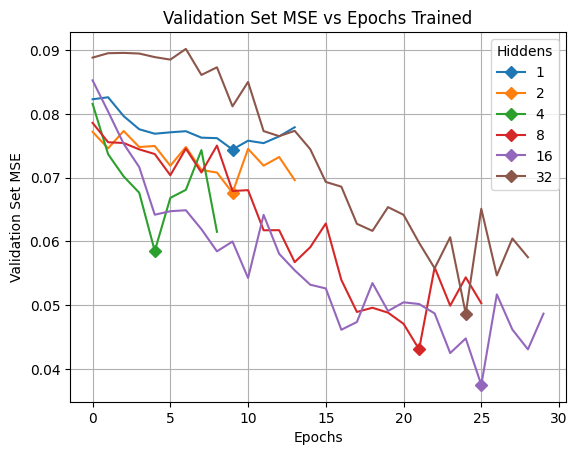

In [764]:
# Validation MSE

def mlp(i, lr):
  x1 = vowel_model_1.val_mse
  x2 = vowel_model_2.val_mse
  x3 = vowel_model_3.val_mse
  x4 = vowel_model_4.val_mse
  x5 = vowel_model_5.val_mse
  x6 = vowel_model_6.val_mse
  data = [x1, x2, x3, x4, x5, x6]
  for x in data: x[-5] = np.amin(x)-.001
  return data[i]

# Graph code
hiddens=[1, 2, 4, 8, 16, 32]

for i, hidden in enumerate(hiddens):
  mse = mlp(i, hidden) # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=hidden)
plt.legend(title="Hiddens", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [765]:
output_table = [
    ["#Hiddens", "#Epochs", "Train MSE", "Val MSE", "Test MSE"],
    [hiddens[0], len(vowel_model_1.scores)+1, vowel_model_1.mse[-1], vowel_model_1.val_mse[-1], vowel_model_1.test_mse[-1]],
    [hiddens[1], len(vowel_model_2.scores)+1, vowel_model_2.mse[-1], vowel_model_2.val_mse[-1], vowel_model_2.test_mse[-1]],
    [hiddens[2], len(vowel_model_3.scores)+1, vowel_model_3.mse[-1], vowel_model_3.val_mse[-1], vowel_model_3.test_mse[-1]],
    [hiddens[3], len(vowel_model_4.scores)+1, vowel_model_4.mse[-1], vowel_model_4.val_mse[-1], vowel_model_4.test_mse[-1]],
    [hiddens[4], len(vowel_model_5.scores)+1, vowel_model_5.mse[-1], vowel_model_5.val_mse[-1], vowel_model_5.test_mse[-1]],
    [hiddens[5], len(vowel_model_6.scores)+1, vowel_model_6.mse[-1], vowel_model_6.val_mse[-1], vowel_model_6.test_mse[-1]]
]

table = tabulate(output_table[1:], output_table[0], tablefmt="fancy_grid")
print(table)

╒════════════╤═══════════╤═════════════╤═══════════╤════════════╕
│   #Hiddens │   #Epochs │   Train MSE │   Val MSE │   Test MSE │
╞════════════╪═══════════╪═════════════╪═══════════╪════════════╡
│          1 │        15 │   0.0764818 │ 0.0778959 │  0.0781523 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│          2 │        15 │   0.0721359 │ 0.0696105 │  0.0692022 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│          4 │        10 │   0.063103  │ 0.0614976 │  0.0691881 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│          8 │        27 │   0.0435878 │ 0.0502969 │  0.047807  │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│         16 │        31 │   0.0490675 │ 0.048663  │  0.0521273 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│         32 │        30 │   0.0456103 │ 0.0575164 │  0.0580461 │
╘════════════╧═══════════╧═════════════╧═══════════╧════════════╛


*Discuss the effect of different numbers of hidden nodes from your graph and table* 

I trained on 6 different numbers of hidden nodes: `1`, `2`, `4`, `8`, `16`, and `32`. As can be seen in the graph, `16` hidden nodes in the hidden layer yielded the lowest validation MSE. After that, at `32` hidden nodes, the model likely began to overfit. `8` hidden nodes actually had the lowest Train MSE and Test MSE though.

### 3.4 (10%) Momentum

Try some different momentum terms between 0 and 1 using the best number of hidden nodes and LR from your earlier experiments.

- Create both a graph and table just like above, except with different momentum values rather than LR.

In [766]:
# Train with different momentum values
vowel_model_1 = MLP(lr=.5, shuffle=True, momentum=0, hidden_layer_widths=[16])
vowel_model_1.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_1.val_scores[-1])

0.4666666666666667


In [767]:
vowel_model_2 = MLP(lr=.5, shuffle=True, momentum=0.1, hidden_layer_widths=[16])
vowel_model_2.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_2.val_scores[-1])

0.32


In [768]:
vowel_model_3 = MLP(lr=.5, shuffle=True, momentum=0.25, hidden_layer_widths=[16])
vowel_model_3.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_3.val_scores[-1])

0.52


In [769]:
vowel_model_4 = MLP(lr=.5, shuffle=True, momentum=0.5, hidden_layer_widths=[16])
vowel_model_4.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_4.val_scores[-1])

0.5866666666666667


In [770]:
vowel_model_5 = MLP(lr=.5, shuffle=True, momentum=0.75, hidden_layer_widths=[16])
vowel_model_5.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_5.val_scores[-1])

0.5333333333333333


In [771]:
vowel_model_6 = MLP(lr=.5, shuffle=True, momentum=0.99, hidden_layer_widths=[16])
vowel_model_6.fit(X_train, y_train, deterministic=1000, use_val=True, val_percent=0.10, X_test=X_test, y_test=y_test, stop_thresh=5)
print(vowel_model_6.val_scores[-1])

0.12


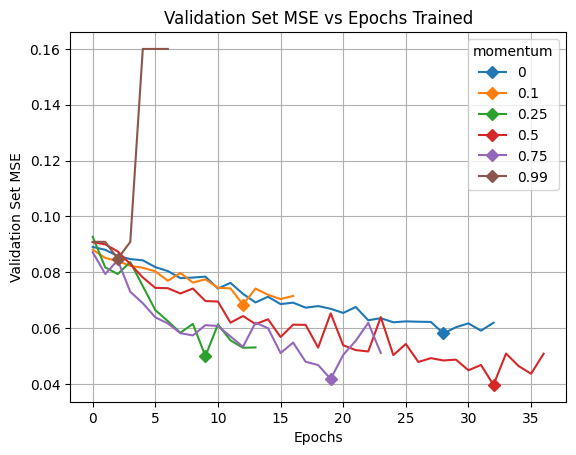

In [772]:
# Validation MSEs

def mlp(i, lr):
  x1 = vowel_model_1.val_mse
  x2 = vowel_model_2.val_mse
  x3 = vowel_model_3.val_mse
  x4 = vowel_model_4.val_mse
  x5 = vowel_model_5.val_mse
  x6 = vowel_model_6.val_mse
  data = [x1, x2, x3, x4, x5, x6]
  for x in data: x[-5] = np.amin(x)-.001
  return data[i]

# Graph code
momentums=[0, 0.1, 0.25, 0.5, 0.75, 0.99]

for i, m in enumerate(momentums):
  mse = mlp(i, m) # get the MSEs from your own perceptron
  plt.plot(mse, '-D', markevery=[np.argmin(mse)], label=m)
plt.legend(title="momentum", loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Validation Set MSE')
plt.title("Validation Set MSE vs Epochs Trained")
plt.grid()
plt.show()

In [774]:
output_table = [
    ["Momentum", "#Epochs", "Train MSE", "Val MSE", "Test MSE"],
    [momentums[0], len(vowel_model_1.scores)+1, vowel_model_1.mse[-1], vowel_model_1.val_mse[-1], vowel_model_1.test_mse[-1]],
    [momentums[1], len(vowel_model_2.scores)+1, vowel_model_2.mse[-1], vowel_model_2.val_mse[-1], vowel_model_2.test_mse[-1]],
    [momentums[2], len(vowel_model_3.scores)+1, vowel_model_3.mse[-1], vowel_model_3.val_mse[-1], vowel_model_3.test_mse[-1]],
    [momentums[3], len(vowel_model_4.scores)+1, vowel_model_4.mse[-1], vowel_model_4.val_mse[-1], vowel_model_4.test_mse[-1]],
    [momentums[4], len(vowel_model_5.scores)+1, vowel_model_5.mse[-1], vowel_model_5.val_mse[-1], vowel_model_5.test_mse[-1]],
    [momentums[5], len(vowel_model_6.scores)+1, vowel_model_6.mse[-1], vowel_model_6.val_mse[-1], vowel_model_6.test_mse[-1]]
]

table = tabulate(output_table[1:], output_table[0], tablefmt="fancy_grid")
print(table)

╒════════════╤═══════════╤═════════════╤═══════════╤════════════╕
│   Momentum │   #Epochs │   Train MSE │   Val MSE │   Test MSE │
╞════════════╪═══════════╪═════════════╪═══════════╪════════════╡
│       0    │        34 │   0.0513754 │ 0.0619322 │  0.0585313 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│       0.1  │        18 │   0.0652029 │ 0.0715228 │  0.0709904 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│       0.25 │        15 │   0.04898   │ 0.0530803 │  0.0500381 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│       0.5  │        38 │   0.0453905 │ 0.0508292 │  0.0476391 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│       0.75 │        25 │   0.0440267 │ 0.0510924 │  0.0509782 │
├────────────┼───────────┼─────────────┼───────────┼────────────┤
│       0.99 │         8 │   0.16628   │ 0.16      │  0.164222  │
╘════════════╧═══════════╧═════════════╧═══════════╧════════════╛


*Discuss the effect of different momentum values from your graph and table*

I tried `0`, `0.1`, `0.25`, `0.5`, `0.75`, and `0.99` for momentum values. `0.5` had the best validation MSE and test MSE. `0.75` had the best train MSE.

## 4. Scikit-learn Classifier and Comparison

### 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris data set and one data set of your choice.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try some different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [779]:
# Load sklearn MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(8, 8), activation='relu', learning_rate_init=0.1, max_iter=1000, momentum=0.5, early_stopping=True)

# Train on Iris and one other data set
arff_path = "iris.arff"
iris_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = iris_data[:,:4]
y = np.expand_dims(iris_data[:,4], axis=1)

# One-hot encoding
y_hot = np.zeros((np.shape(y)[0], int(np.amax(y) + 1)))
for i in range(np.shape(y_hot)[1]):
    y_hot[:,i] = (y[:,0] == i).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2)

mlp.fit(X_train, y_train)
print(mlp.best_validation_score_)
print(mlp.score(X_test,y_test))

1.0
0.8333333333333334


In [680]:
mlp = MLPClassifier(hidden_layer_sizes=(8), activation='tanh', learning_rate_init=0.1, max_iter=1000, momentum=0.5, early_stopping=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2)

mlp.fit(X_train, y_train)
print(mlp.best_validation_score_)
print(mlp.score(X_test,y_test))

0.9166666666666666
0.9


In [681]:
# No early stopping
mlp = MLPClassifier(hidden_layer_sizes=(16), activation='tanh', learning_rate_init=0.01, max_iter=5000, momentum=0.9)

# X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2)

mlp.fit(X_train, y_train)
# print(mlp.best_validation_score_)
print(mlp.score(X_test,y_test))

0.9333333333333333


In [678]:
mlp = MLPClassifier(hidden_layer_sizes=(8), activation='logistic', learning_rate_init=0.1, max_iter=1000, nesterovs_momentum=True,momentum=0.5, early_stopping=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2)

mlp.fit(X_train, y_train)
print(mlp.best_validation_score_)
print(mlp.score(X_test,y_test))

0.9166666666666666
0.6333333333333333


*Discussion*

I tried changing several different hyperparameters (all on the same train and test sets). I noticed that tanh as an activation function did much better than the default relu. Overall, it did very well on the task with most of my different hyperparamters. The nesterovs_momentum didn't seem as good as normal momentum. Decreasing the learning rate also seemed to imrprove the model as well. Increasing the number of hidden nodes in the hidden layer seemed to help a lot as well.

### 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid or random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [780]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Load sklearn MLP
# mlp = MLPClassifier(hidden_layer_sizes=(8), activation='tanh', learning_rate_init=0.1, max_iter=1000, momentum=0.5, early_stopping=True)

mlp_pipe = Pipeline([('mlp', MLPClassifier())])

params = [{
    'mlp__activation': ['relu','logistic', 'tanh'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1, 0.5, 1, 10],
    'mlp__momentum': [0, 0.1, 0.5, 0.9],
    'mlp__hidden_layer_sizes': [(8), (16), (4,4), (8, 8), (32)],
    'mlp__early_stopping': [True]
}]

gs_mlp = GridSearchCV(mlp_pipe, param_grid=params, scoring='accuracy', cv=5)

gs_mlp.fit(X_train, y_train)
print(gs_mlp.best_params_)
print(gs_mlp.best_score_)


{'mlp__activation': 'tanh', 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': 16, 'mlp__learning_rate_init': 0.1, 'mlp__momentum': 0.1}
0.875


*Discussion*

I used sklearn's GridSearchCV function to do a grid search. As seen above, I tried three different activation functions: `['relu','logistic', 'tanh']`, 6 different learning rates: `[0.001, 0.01, 0.1, 0.5, 1, 10]`, 4 different momentum values: `[0, 0.1, 0.5, 0.9]`, 5 different hiddne layer node configurations: `[(8), (16), (4,4), (8, 8), (32)]`, and I made sure to include early stopping on all of them.

The resulting best hyperparameters were: `{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': 16, 'mlp__learning_rate_init': 0.1, 'mlp__momentum': 0.1}`

The restulting best score was: `0.875`

### 5. (Optional 5% Extra credit) For the Iris data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, momentum, and any other hyperparamters you want to consider.  

*Discuss your results and any differences*